# Multi-Label Quality Classification via CNN

In [1]:
import os
import glob
import json
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models, optimizers, losses, metrics, backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
from sklearn.metrics import classification_report

## Loading and Preprocessing Data

**Dataset Loading:**  
The dataset is loaded by reading all `.wav` audio files from a specified directory and parsing their corresponding metadata from a JSON file. Each audio file is matched with its label information, which contains a list of descriptive timbre qualities. These qualities are then encoded into a binary multi-label format based on a predefined class list.

**Data Processing:**  
Each audio file is segmented into overlapping 1-second windows, and for each segment, log-Mel spectrograms are extracted along with their delta features to capture both spectral content and temporal variation. These are stacked into 2-channel input tensors. If an audio file is shorter than the target duration, it is zero-padded; if longer, it is truncated. All resulting segments are converted to `float32` for efficiency and paired with their corresponding labels before being split into training, validation, and test sets.

**Why use audio segments instead of full recordings?**

Segmenting audio into short overlapping chunks (e.g., 1-second segments) helps increase the number of training samples and captures local timbre variations more effectively. Whole-audio prediction often performs poorly because it loses fine-grained temporal details and struggles with multi-label timbre detection. Segment-based models learn more robust and generalizable patterns.

In [ ]:
# ========== Path and parameter settings ==========
AUDIO_DIR = "../data/audio"
JSON_PATH = "../data/examples.json"

SAMPLE_RATE = 16000
N_MELS = 96
WINDOW_SIZE_SEC = 1.0
HOP_RATIO = 0.5
MAX_DURATION = 4.0
FRAME_TRIM = 96

quality_classes = [
    'bright', 'dark', 'distortion', 'fast_decay', 'long_release',
    'multiphonic', 'nonlinear_env', 'percussive', 'reverb'
]

# ========== Label encoding function ==========
def encode_labels(qualities_str, class_list):
    label = [0] * len(class_list)
    for q in qualities_str:
        if q in class_list:
            label[class_list.index(q)] = 1
    return label

# ========== Feature extraction function ==========
def extract_logmel_delta(path):
    try:
        y, _ = librosa.load(path, sr=SAMPLE_RATE)
        target_len = int(SAMPLE_RATE * MAX_DURATION)
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]

        win_len = int(WINDOW_SIZE_SEC * SAMPLE_RATE)
        hop_len = int(win_len * HOP_RATIO)

        segments = []
        for start in range(0, len(y) - win_len + 1, hop_len):
            seg = y[start:start + win_len]
            mel = librosa.feature.melspectrogram(
                y=seg, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=512, hop_length=256
            )
            logmel = librosa.power_to_db(mel, ref=np.max)
            logmel = logmel[:, :FRAME_TRIM]
            delta = librosa.feature.delta(logmel)
            stacked = np.stack([logmel, delta], axis=-1)
            segments.append(stacked)
        return np.array(segments)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

# ========== Main pipeline ==========
X = []
Y = []

with open(JSON_PATH, "r") as f:
    metadata = json.load(f)

file_paths = sorted(glob.glob(os.path.join(AUDIO_DIR, "*.wav")))

for path in file_paths:
    basename = os.path.splitext(os.path.basename(path))[0]
    if basename not in metadata:
        print(f"Warning: {basename} not in metadata.")
        continue

    entry = metadata[basename]
    label = encode_labels(entry["qualities_str"], quality_classes)
    features = extract_logmel_delta(path)

    if features is not None and len(features) > 0:
        for segment in features:
            X.append(segment.astype(np.float32))  # Convert to float32 to save memory
            Y.append(np.array(label, dtype=np.float32))  # Multi-label
    else:
        print(f"Skipped: {basename}")

X = np.array(X)
Y = np.array(Y)
print("Total segments:", len(X))

# ========== Split Train / Val / Test ==========
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=6600)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=6600)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

Total segments: 28672
Train: (22937, 96, 63, 2)
Val  : (2867, 96, 63, 2)
Test : (2868, 96, 63, 2)


## Building the Model

**Model Overview:**

This model is a Convolutional Neural Network (CNN) designed to take as input a 2-channel image-like tensor of shape `(96, 96, 2)` — typically a stacked log-Mel spectrogram and its delta features. It outputs a 9-dimensional vector with sigmoid activations to support multi-label classification of timbre qualities.


**Model Architecture Breakdown:**

1. `K.clear_session()` 
   Clears any previously stored models in the Keras backend to avoid cluttering the memory (especially useful in notebook environments).

2. First Convolution Block:  
   - `Conv2D(24, (3, 3))`: Applies 24 filters of size 3×3 with padding to preserve spatial dimensions.
   - `BatchNormalization`: Normalizes the feature maps for better training stability.
   - `ReLU`: Applies non-linearity.
   - `MaxPooling(2×2)`: Downsamples the feature maps by a factor of 2.

3. Second Convolution Block:
   - Same as the first block but with 32 filters.

4. Third Convolution Block: 
   - Same as above, but now with 64 filters, allowing deeper feature extraction.

5. Fourth Convolution Block (no pooling):  
   - Uses 128 filters, increases feature complexity.
   - No max pooling here — we retain more spatial information for the next step.

6. GlobalMaxPooling2D: 
   - Reduces each feature map to a single value, resulting in a 1D vector.
   - Keeps the most prominent activation across the entire feature map.

7. Dense Layers:
   - `Dense(128, relu)`: Fully connected layer for further abstraction.
   - `Dense(num_classes, sigmoid)`: Final output layer with sigmoid activations, one per class, allowing independent probability estimates for each label (multi-label scenario).

In [3]:
def get_multilabel_cnn(input_shape=(96, 96, 2), num_classes=9):
    K.clear_session()
    model = models.Sequential()
    
    model.add(layers.Conv2D(24, (3, 3), padding="same", input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))

    model.add(layers.GlobalMaxPooling2D())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(num_classes, activation="sigmoid"))  # Multi-label

    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss=losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )
    return model

EarlyStopping is a training callback that helps prevent overfitting by stopping training early if the model stops improving on the validation set.

In [ ]:
# EarlyStopping: Stop training if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',         # You can also use 'val_accuracy'
    patience=5,                 # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore model from the best epoch
)

# ModelCheckpoint: Save best model during training
model_ckpt = ModelCheckpoint(
    filepath='best_model.h5',   # File to save the best model
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False     # Save full model (set to True if only saving weights)
)

In [ ]:
model = get_multilabel_cnn(input_shape=(96, 63, 2), num_classes=9)

## Training the Model

In Keras, the default `"accuracy"` metric for multi-label classification is actually binary accuracy, which evaluates each label independently. It checks whether the predicted value matches the true value for each label position, then averages the results across all labels and samples. This means that if a sample has 9 labels (as in your case), even a single label mismatch contributes to a reduction in overall accuracy. For example, if the model predicts `[1, 0, 1, 1, 0, 0, 1, 0, 1]` for a sample whose true label is `[1, 0, 1, 0, 0, 0, 1, 0, 1]`, it only makes one mistake—but that one incorrect label still lowers the average accuracy. This is why the reported accuracy may appear low, even when the model performs well overall.

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, model_ckpt]
)

Epoch 1/50
717/717 [==============================] - 22s 18ms/step - loss: 0.3228 - accuracy: 0.3399 - val_loss: 0.2672 - val_accuracy: 0.3819
Epoch 2/50
717/717 [==============================] - 13s 18ms/step - loss: 0.2434 - accuracy: 0.4195 - val_loss: 0.2310 - val_accuracy: 0.4618
Epoch 3/50
717/717 [==============================] - 13s 18ms/step - loss: 0.2125 - accuracy: 0.4556 - val_loss: 0.2062 - val_accuracy: 0.4901
Epoch 4/50
717/717 [==============================] - 13s 18ms/step - loss: 0.1903 - accuracy: 0.4724 - val_loss: 0.1877 - val_accuracy: 0.5089
Epoch 5/50
717/717 [==============================] - 13s 19ms/step - loss: 0.1729 - accuracy: 0.4866 - val_loss: 0.1744 - val_accuracy: 0.5246
Epoch 6/50
717/717 [==============================] - 13s 18ms/step - loss: 0.1589 - accuracy: 0.4971 - val_loss: 0.1652 - val_accuracy: 0.4956
Epoch 7/50
717/717 [==============================] - 13s 18ms/step - loss: 0.1477 - accuracy: 0.5022 - val_loss: 0.1580 - val_accuracy:

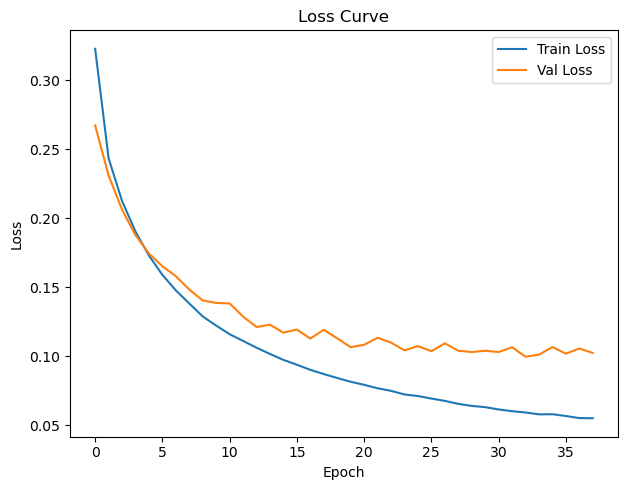

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


## Evaluate the Model

During the evaluation phase, the model’s raw output probabilities (`y_val_prob`) are first converted into binary predictions using a threshold, typically `0.5`, like so:

```python
y_val_bin = (y_val_prob >= 0.5).astype(int)
```

This step binarizes the sigmoid outputs for each label, turning them into final multi-label predictions. Then, more appropriate evaluation metrics for multi-label tasks are applied:

- Subset Accuracy checks whether all predicted labels for a sample exactly match the ground truth. It is strict but provides a clear signal of complete correctness.
- Hamming Loss measures the fraction of incorrect labels over all labels and samples—providing a more tolerant, fine-grained view.
- Macro F1 calculates the F1 score for each label independently and then averages them, ensuring equal weight is given to all labels, even if some are rare.
- Micro F1 aggregates all true positives, false positives, and false negatives globally, making it more sensitive to overall performance across imbalanced labels.

These metrics better reflect multi-label performance than raw accuracy during training, as they capture both exact matches and partial correctness in a structured, interpretable way.

In [19]:
def evaluate_model(y_true, y_pred):
    print("Subset Accuracy:", accuracy_score(y_true, y_pred))
    print("Hamming Loss:", hamming_loss(y_true, y_pred))
    print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
    print("Micro F1:", f1_score(y_true, y_pred, average='micro'))


In [33]:
def safe_predict(model, X, batch_size=32):
    """Safely predict large dataset in batches"""
    preds = []
    num_batches = int(np.ceil(len(X) / batch_size))
    
    for i in range(num_batches):
        batch = X[i * batch_size : (i + 1) * batch_size]
        pred = model.predict(batch, verbose=0)
        preds.append(pred)
    
    return np.vstack(preds)


y_train_prob = safe_predict(model, X_train, batch_size=32)

y_train_bin = (y_train_prob >= 0.5).astype(int)

In [ ]:
y_val_prob = model.predict(X_val)

y_val_bin = (y_val_prob >= 0.5).astype(int)

90/90 [==============================] - 0s 4ms/step


The model performs well on both the training and validation sets. On the training set, it achieves high Subset Accuracy (88.3%) and strong F1 scores (Macro: 0.89, Micro: 0.92), indicating it captures both individual label quality and overall performance. Validation metrics are slightly lower (Subset Accuracy: 75.6%, Macro F1: 0.83, Micro F1: 0.86), suggesting some generalization gap but still solid multi-label classification performance. The low Hamming Loss on both sets confirms that most labels are predicted correctly.

In [35]:
print("Train Set Performance:")
evaluate_model(y_train, y_train_bin)

print("\nValidation Set Performance:")
evaluate_model(y_val, y_val_bin)

Train Set Performance:
Subset Accuracy: 0.8829838252604961
Hamming Loss: 0.021624449579282383
Macro F1: 0.8899210355210128
Micro F1: 0.9233174150547978

Validation Set Performance:
Subset Accuracy: 0.7558423439134985
Hamming Loss: 0.037631283184125876
Macro F1: 0.8349590320827256
Micro F1: 0.8627949696198954


In [ ]:
y_pred_prob = model.predict(X_test)               
y_pred_bin = (y_pred_prob >= 0.5).astype(int)     


90/90 [==============================] - 2s 15ms/step


Per-Label Performance:

- Most labels like "bright", "dark", "distortion", "fast_decay", and "reverb" show strong performance with F1-scores above 0.83.
- "long_release" also performs well (F1 = 0.90), indicating balanced precision and recall.
- However, some labels such as "multiphonic", "nonlinear_env", and especially "percussive" show lower recall (e.g., only 0.43 for "percussive"), meaning the model struggles to detect these when they are present.

Overall Metrics:

- Micro average (F1 = 0.85): Reflects good overall performance by aggregating all true/false positives/negatives across labels.
- Macro average (F1 = 0.82): Weighs each label equally—so this lower score compared to micro avg suggests the model performs worse on some underrepresented or harder-to-predict labels.
- Weighted average (F1 = 0.84): Balances label performance by their frequency—slightly better than macro but still lower than micro.
- Samples average (F1 = 0.61): Measures how well the model predicts the full set of labels per sample. Lower value indicates that predicting all tags for each individual sample is still challenging.

In [ ]:
print(classification_report(y_test, y_pred_bin, target_names=quality_classes, zero_division=0))

               precision    recall  f1-score   support

       bright       0.91      0.77      0.83       431
         dark       0.93      0.76      0.84       493
   distortion       0.93      0.82      0.87       659
   fast_decay       0.92      0.93      0.93       493
 long_release       0.95      0.85      0.90       399
  multiphonic       0.98      0.55      0.71       111
nonlinear_env       0.99      0.68      0.81       320
   percussive       0.90      0.43      0.58       287
       reverb       0.94      0.85      0.89       647

    micro avg       0.93      0.78      0.85      3840
    macro avg       0.94      0.74      0.82      3840
 weighted avg       0.93      0.78      0.84      3840
  samples avg       0.66      0.60      0.61      3840



In [ ]:
# exact match accuracy
acc = accuracy_score(y_test, y_pred_bin)


print("Hamming Loss:", hamming_loss(y_test, y_pred_bin))
print("Accuracy (Exact Match):", acc)
print("Macro F1 Score:", f1_score(y_test, y_pred_bin, average='macro'))
print("Micro F1 Score:", f1_score(y_test, y_pred_bin, average='micro'))


Hamming Loss: 0.04083372075003874
Accuracy (Exact Match): 0.7426778242677824
Macro F1 Score: 0.8168009771669897
Micro F1 Score: 0.8504115810388874


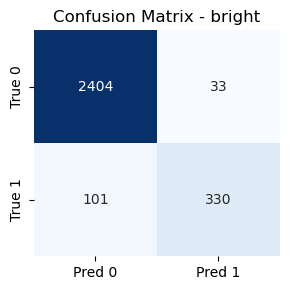

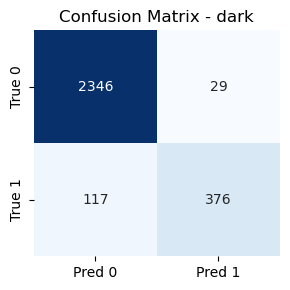

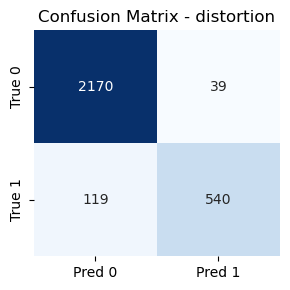

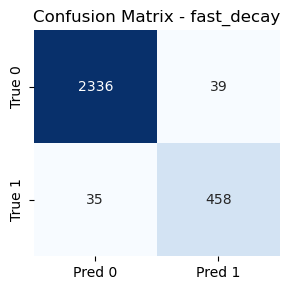

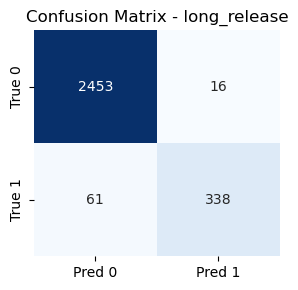

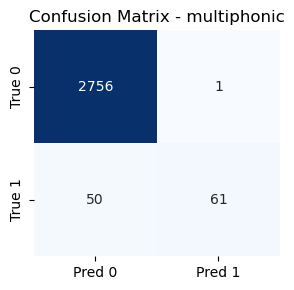

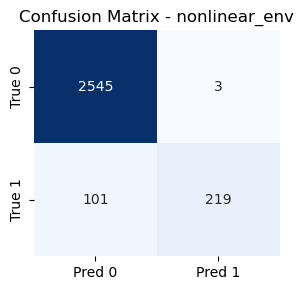

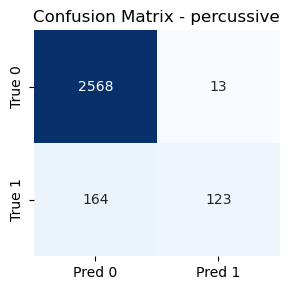

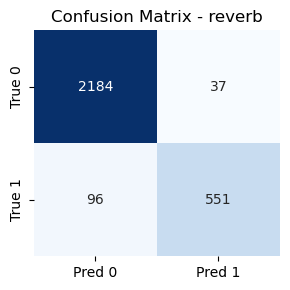

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mtx = multilabel_confusion_matrix(y_test, y_pred_bin)

label_names = [
    'bright', 'dark', 'distortion', 'fast_decay', 'long_release',
    'multiphonic', 'nonlinear_env', 'percussive', 'reverb'
]

for i, mtx in enumerate(conf_mtx):
    plt.figure(figsize=(3, 3))
    sns.heatmap(mtx, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix - {label_names[i]}")
    plt.tight_layout()
    plt.show()


## Conclusion

While the model demonstrates reasonable performance—particularly on the training set and with consistent Hamming Loss across both splits—the observed generalization gap and relatively lower validation metrics indicate potential limitations in capturing complex label dependencies. Given that the Res2Net-based model consistently outperforms in terms of both accuracy and F1 scores, especially on the validation and test sets, this baseline architecture was not selected for the final system. Nonetheless, the results confirm its value as an interpretable benchmark in the multi-label classification task.